In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0-alpha0
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)
matplotlib 3.1.1
numpy 1.16.2
pandas 0.25.0
sklearn 0.21.3
tensorflow 2.0.0-alpha0
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)


.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)


In [5]:
# RandomizedSearchCV
# 1. 转化为sklearn的model
# 2. 定义参数集合
# 3. 搜索参数

def build_model(hidden_layers = 1, layer_size = 30, learning_rate = 3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation='relu',
                                 input_shape=x_train.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size, activation = 'relu'))
        
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss = 'mse', optimizer = optimizer)
    return model

sklearn_model = keras.wrappers.scikit_learn.KerasRegressor(build_model)
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]
history = sklearn_model.fit(x_train_scaled, y_train, epochs = 100,
                  validation_data = (x_valid_scaled, y_valid),
                  callbacks = callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 0s 35us/sample - loss: 1.1101 - val_loss: 0.7320
Epoch 2/100
11610/11610 [==============================] - 0s 22us/sample - loss: 0.6076 - val_loss: 0.6067
Epoch 3/100
11610/11610 [==============================] - 0s 23us/sample - loss: 0.5291 - val_loss: 0.5459
Epoch 4/100
11610/11610 [==============================] - 0s 22us/sample - loss: 0.4916 - val_loss: 0.5120
Epoch 5/100
11610/11610 [==============================] - 0s 22us/sample - loss: 0.4694 - val_loss: 0.4911
Epoch 6/100
11610/11610 [==============================] - 0s 24us/sample - loss: 0.4557 - val_loss: 0.4851
Epoch 7/100
11610/11610 [==============================] - 0s 23us/sample - loss: 0.4489 - val_loss: 0.4703
Epoch 8/100
11610/11610 [==============================] - 0s 23us/sample - loss: 0.4408 - val_loss: 0.4592
Epoch 9/100
11610/11610 [==============================] - 0s 22us/sample - loss: 0.433

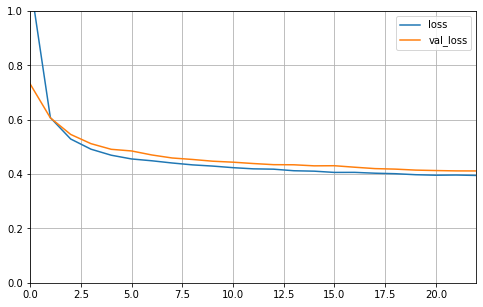

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

In [13]:
from scipy.stats import reciprocal
param_distribution = {
    "hidden_layers":[1, 2, 3, 4],
    "layer_size": np.arange(1, 100),
    "learning_rate":reciprocal(1e-4, 1e-2),
}

from sklearn.model_selection import RandomizedSearchCV

random_search_cv = RandomizedSearchCV(sklearn_model, 
                                      param_distribution, 
                                      n_iter = 10,
                                      n_jobs = 1)
random_search_cv.fit(x_train_scaled, y_train, epochs = 100,
                     validation_data = (x_valid_scaled, y_valid),
                     callbacks = callbacks)

/home/tensorflow/environment/tf2_py3_new/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 46us/sample - loss: 1.0990 - val_loss: 0.6876
Epoch 2/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.6247 - val_loss: 0.6182
Epoch 3/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.5359 - val_loss: 0.5238
Epoch 4/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.4871 - val_loss: 0.4861
Epoch 5/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.4581 - val_loss: 0.4596
Epoch 6/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.4397 - val_loss: 0.4414
Epoch 7/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4269 - val_loss: 0.4298
Epoch 8/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4151 - val_loss: 0.4209
Epoch 9/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4067 - val_loss: 0.409

3870/3870 [==============================] - 0s 11us/sample - loss: 0.3757
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 48us/sample - loss: 3.2212 - val_loss: 1.7015
Epoch 2/100
7740/7740 [==============================] - 0s 31us/sample - loss: 1.2514 - val_loss: 1.0029
Epoch 3/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.8962 - val_loss: 0.8176
Epoch 4/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.7596 - val_loss: 0.7400
Epoch 5/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.6994 - val_loss: 0.7042
Epoch 6/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.6694 - val_loss: 0.6838
Epoch 7/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.6496 - val_loss: 0.6679
Epoch 8/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.6343 - val_loss: 0.6528
Epoch 9/100
7740/7740 [======

7740/7740 [==============================] - 0s 32us/sample - loss: 0.5149 - val_loss: 0.5501
Epoch 16/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.5066 - val_loss: 0.5417
Epoch 17/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.4993 - val_loss: 0.5336
Epoch 18/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.4921 - val_loss: 0.5265
Epoch 19/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4858 - val_loss: 0.5193
Epoch 20/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4792 - val_loss: 0.5134
Epoch 21/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4736 - val_loss: 0.5078
Epoch 22/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.4685 - val_loss: 0.5013
Epoch 23/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.4631 - val_loss: 0.4959
Epoch 24/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 34us/sample - loss: 0.3825 - val_loss: 0.4218
Epoch 39/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.3805 - val_loss: 0.4181
Epoch 40/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.3784 - val_loss: 0.4168
Epoch 41/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.3758 - val_loss: 0.4152
Epoch 42/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.3745 - val_loss: 0.4120
Epoch 43/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.3727 - val_loss: 0.4092
Epoch 44/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.3709 - val_loss: 0.4088
Epoch 45/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.3689 - val_loss: 0.4064
Epoch 46/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.3675 - val_loss: 0.4050
Epoch 47/100
3870/3870 [==========================

7740/7740 [==============================] - 0s 30us/sample - loss: 0.3865 - val_loss: 0.4140
Epoch 9/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.3763 - val_loss: 0.4085
Epoch 10/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3729 - val_loss: 0.4102
Epoch 11/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.3652 - val_loss: 0.3961
Epoch 12/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3591 - val_loss: 0.3955
Epoch 13/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3600 - val_loss: 0.3897
Epoch 14/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.3535 - val_loss: 0.3858
Epoch 15/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.3491 - val_loss: 0.3862
Epoch 16/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3477 - val_loss: 0.3833
Epoch 17/100
7740/7740 [===========================

7740/7740 [==============================] - 0s 27us/sample - loss: 0.5172 - val_loss: 0.5518
Epoch 14/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.5078 - val_loss: 0.5446
Epoch 15/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.4994 - val_loss: 0.5342
Epoch 16/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.4918 - val_loss: 0.5253
Epoch 17/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.4848 - val_loss: 0.5189
Epoch 18/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.4785 - val_loss: 0.5148
Epoch 19/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.4724 - val_loss: 0.5070
Epoch 20/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.4669 - val_loss: 0.4994
Epoch 21/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.4619 - val_loss: 0.4960
Epoch 22/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 28us/sample - loss: 0.3824 - val_loss: 0.4222
Epoch 39/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3802 - val_loss: 0.4187
Epoch 40/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3785 - val_loss: 0.4165
Epoch 41/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.3765 - val_loss: 0.4146
Epoch 42/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.3744 - val_loss: 0.4133
Epoch 43/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3725 - val_loss: 0.4095
Epoch 44/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3706 - val_loss: 0.4100
Epoch 45/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.3692 - val_loss: 0.4058
Epoch 46/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3673 - val_loss: 0.4058
Epoch 47/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 31us/sample - loss: 0.4604 - val_loss: 0.4927
Epoch 20/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4553 - val_loss: 0.4857
Epoch 21/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.4506 - val_loss: 0.4810
Epoch 22/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4463 - val_loss: 0.4752
Epoch 23/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4416 - val_loss: 0.4712
Epoch 24/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4382 - val_loss: 0.4656
Epoch 25/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.4342 - val_loss: 0.4633
Epoch 26/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.4306 - val_loss: 0.4571
Epoch 27/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.4272 - val_loss: 0.4531
Epoch 28/100
7740/7740 [==========================

3870/3870 [==============================] - 0s 12us/sample - loss: 0.4104
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 49us/sample - loss: 4.3421 - val_loss: 3.9331
Epoch 2/100
7740/7740 [==============================] - 0s 31us/sample - loss: 3.2994 - val_loss: 2.9881
Epoch 3/100
7740/7740 [==============================] - 0s 30us/sample - loss: 2.4898 - val_loss: 2.2792
Epoch 4/100
7740/7740 [==============================] - 0s 32us/sample - loss: 1.9138 - val_loss: 1.8124
Epoch 5/100
7740/7740 [==============================] - 0s 32us/sample - loss: 1.5561 - val_loss: 1.5278
Epoch 6/100
7740/7740 [==============================] - 0s 31us/sample - loss: 1.3353 - val_loss: 1.3419
Epoch 7/100
7740/7740 [==============================] - 0s 31us/sample - loss: 1.1873 - val_loss: 1.2087
Epoch 8/100
7740/7740 [==============================] - 0s 32us/sample - loss: 1.0780 - val_loss: 1.1072
Epoch 9/100
7740/7740 [======

7740/7740 [==============================] - 0s 33us/sample - loss: 2.3570 - val_loss: 2.2286
Epoch 5/100
7740/7740 [==============================] - 0s 32us/sample - loss: 1.9230 - val_loss: 1.8856
Epoch 6/100
7740/7740 [==============================] - 0s 31us/sample - loss: 1.6624 - val_loss: 1.6768
Epoch 7/100
7740/7740 [==============================] - 0s 33us/sample - loss: 1.4943 - val_loss: 1.5250
Epoch 8/100
7740/7740 [==============================] - 0s 30us/sample - loss: 1.3671 - val_loss: 1.4056
Epoch 9/100
7740/7740 [==============================] - 0s 34us/sample - loss: 1.2665 - val_loss: 1.3073
Epoch 10/100
7740/7740 [==============================] - 0s 32us/sample - loss: 1.1831 - val_loss: 1.2216
Epoch 11/100
7740/7740 [==============================] - 0s 33us/sample - loss: 1.1103 - val_loss: 1.1473
Epoch 12/100
7740/7740 [==============================] - 0s 33us/sample - loss: 1.0473 - val_loss: 1.0815
Epoch 13/100
7740/7740 [==============================]

7740/7740 [==============================] - 0s 30us/sample - loss: 4.1306 - val_loss: 3.8945
Epoch 3/100
7740/7740 [==============================] - 0s 30us/sample - loss: 3.3127 - val_loss: 3.1084
Epoch 4/100
7740/7740 [==============================] - 0s 30us/sample - loss: 2.6343 - val_loss: 2.4597
Epoch 5/100
7740/7740 [==============================] - 0s 31us/sample - loss: 2.0931 - val_loss: 1.9590
Epoch 6/100
7740/7740 [==============================] - 0s 32us/sample - loss: 1.6966 - val_loss: 1.6123
Epoch 7/100
7740/7740 [==============================] - 0s 33us/sample - loss: 1.4315 - val_loss: 1.3917
Epoch 8/100
7740/7740 [==============================] - 0s 31us/sample - loss: 1.2694 - val_loss: 1.2621
Epoch 9/100
7740/7740 [==============================] - 0s 31us/sample - loss: 1.1621 - val_loss: 1.1763
Epoch 10/100
7740/7740 [==============================] - 0s 31us/sample - loss: 1.0856 - val_loss: 1.1130
Epoch 11/100
7740/7740 [==============================] -

7740/7740 [==============================] - 0s 25us/sample - loss: 1.6531 - val_loss: 1.6524
Epoch 8/100
7740/7740 [==============================] - 0s 26us/sample - loss: 1.4733 - val_loss: 1.4904
Epoch 9/100
7740/7740 [==============================] - 0s 26us/sample - loss: 1.3371 - val_loss: 1.3649
Epoch 10/100
7740/7740 [==============================] - 0s 26us/sample - loss: 1.2314 - val_loss: 1.2657
Epoch 11/100
7740/7740 [==============================] - ETA: 0s - loss: 1.142 - 0s 26us/sample - loss: 1.1472 - val_loss: 1.1857
Epoch 12/100
7740/7740 [==============================] - 0s 25us/sample - loss: 1.0795 - val_loss: 1.1203
Epoch 13/100
7740/7740 [==============================] - 0s 26us/sample - loss: 1.0239 - val_loss: 1.0660
Epoch 14/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.9778 - val_loss: 1.0206
Epoch 15/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.9391 - val_loss: 0.9823
Epoch 16/100
7740/7740 [====

7740/7740 [==============================] - 0s 25us/sample - loss: 0.8255 - val_loss: 0.8752
Epoch 14/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.7980 - val_loss: 0.8472
Epoch 15/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.7753 - val_loss: 0.8242
Epoch 16/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.7567 - val_loss: 0.8049
Epoch 17/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.7408 - val_loss: 0.7886
Epoch 18/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.7271 - val_loss: 0.7749
Epoch 19/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.7152 - val_loss: 0.7632
Epoch 20/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.7048 - val_loss: 0.7530
Epoch 21/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.6954 - val_loss: 0.7441
Epoch 22/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 25us/sample - loss: 0.6372 - val_loss: 0.7208
Epoch 25/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.6298 - val_loss: 0.7134
Epoch 26/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.6235 - val_loss: 0.7071
Epoch 27/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.6180 - val_loss: 0.7015
Epoch 28/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.6133 - val_loss: 0.6965
Epoch 29/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.6091 - val_loss: 0.6921
Epoch 30/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.6053 - val_loss: 0.6880
Epoch 31/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.6018 - val_loss: 0.6842
Epoch 32/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.5987 - val_loss: 0.6807
Epoch 33/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 25us/sample - loss: 0.6154 - val_loss: 0.6507
Epoch 44/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.6128 - val_loss: 0.6480
Epoch 45/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.6102 - val_loss: 0.6453
Epoch 46/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.6078 - val_loss: 0.6427
Epoch 47/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.6053 - val_loss: 0.6402
Epoch 48/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.6029 - val_loss: 0.6377
Epoch 49/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.6006 - val_loss: 0.6352
Epoch 50/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.5983 - val_loss: 0.6328
Epoch 51/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.5961 - val_loss: 0.6304
Epoch 52/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 25us/sample - loss: 0.6152 - val_loss: 0.6756
Epoch 52/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.6123 - val_loss: 0.6725
Epoch 53/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.6094 - val_loss: 0.6695
Epoch 54/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.6067 - val_loss: 0.6666
Epoch 55/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.6039 - val_loss: 0.6637
Epoch 56/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.6012 - val_loss: 0.6607
Epoch 57/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.5986 - val_loss: 0.6579
Epoch 58/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.5960 - val_loss: 0.6551
Epoch 59/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.5934 - val_loss: 0.6523
Epoch 60/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 27us/sample - loss: 0.6310 - val_loss: 0.7005
Epoch 45/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.6286 - val_loss: 0.6980
Epoch 46/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.6263 - val_loss: 0.6955
Epoch 47/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.6239 - val_loss: 0.6931
Epoch 48/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.6216 - val_loss: 0.6906
Epoch 49/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.6194 - val_loss: 0.6882
Epoch 50/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.6172 - val_loss: 0.6858
Epoch 51/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.6150 - val_loss: 0.6835
Epoch 52/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.6128 - val_loss: 0.6811
Epoch 53/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 31us/sample - loss: 1.2790 - val_loss: 1.0740
Epoch 3/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.9026 - val_loss: 0.8649
Epoch 4/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.7548 - val_loss: 0.7622
Epoch 5/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.6823 - val_loss: 0.7110
Epoch 6/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.6447 - val_loss: 0.6816
Epoch 7/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.6220 - val_loss: 0.6621
Epoch 8/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.6049 - val_loss: 0.6463
Epoch 9/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.5906 - val_loss: 0.6323
Epoch 10/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.5776 - val_loss: 0.6198
Epoch 11/100
7740/7740 [==============================] -

7740/7740 [==============================] - 0s 33us/sample - loss: 0.4613 - val_loss: 0.5097
Epoch 27/100
7740/7740 [==============================] - ETA: 0s - loss: 0.463 - 0s 33us/sample - loss: 0.4571 - val_loss: 0.5048
Epoch 28/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.4530 - val_loss: 0.5000
Epoch 29/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.4492 - val_loss: 0.4958
Epoch 30/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.4456 - val_loss: 0.4919
Epoch 31/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.4420 - val_loss: 0.4880
Epoch 32/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.4387 - val_loss: 0.4846
Epoch 33/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.4357 - val_loss: 0.4813
Epoch 34/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.4326 - val_loss: 0.4774
Epoch 35/100
7740/7740 [==

7740/7740 [==============================] - 0s 31us/sample - loss: 0.4482 - val_loss: 0.4675
Epoch 50/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.4464 - val_loss: 0.4650
Epoch 51/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4443 - val_loss: 0.4624
Epoch 52/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.4421 - val_loss: 0.4601
Epoch 53/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4404 - val_loss: 0.4579
Epoch 54/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4382 - val_loss: 0.4562
Epoch 55/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4363 - val_loss: 0.4544
Epoch 56/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4346 - val_loss: 0.4525
Epoch 57/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4330 - val_loss: 0.4503
Epoch 58/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 32us/sample - loss: 0.8410 - val_loss: 0.8716
Epoch 6/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.7739 - val_loss: 0.8129
Epoch 7/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.7265 - val_loss: 0.7718
Epoch 8/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.6915 - val_loss: 0.7416
Epoch 9/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.6653 - val_loss: 0.7194
Epoch 10/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.6448 - val_loss: 0.7011
Epoch 11/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.6277 - val_loss: 0.6851
Epoch 12/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.6134 - val_loss: 0.6717
Epoch 13/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.6009 - val_loss: 0.6599
Epoch 14/100
7740/7740 [==============================

11610/11610 [==============================] - 0s 28us/sample - loss: 0.3386 - val_loss: 0.3535
Epoch 20/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.3364 - val_loss: 0.3764


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fdc18dc6160>,
                   iid='warn', n_iter=10, n_jobs=1,
                   param_distributions={'hidden_layers': [1, 2, 3, 4],
                                        'layer_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 3...46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdc043628d0>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_s

In [14]:
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)

{'hidden_layers': 3, 'layer_size': 64, 'learning_rate': 0.0034917636465232427}
-0.35353983371910813


In [15]:
model = random_search_cv.best_estimator_.model
model.evaluate(x_test_scaled, y_test)

5160/5160 [==============================] - 0s 16us/sample - loss: 0.3862


0.38619703863018245